# Statistical foundations of Machine Learning

## INFO-F-422 House Prices project

Madalina Ciortan

May 11, 2017

## Overview

The current project aims at solving the House Prices Kaggle competition :https://www.kaggle.com/c/house-prices-advanced-regression-techniques
In order to predict the house Sale Price, this report implements the following steps:
- data visualisation, exploration and selection
- imputation
- feature selection
- model selection
- ensemble techniques
- prediction
- conclusion

In [34]:
library(dummies)
library(ggplot2)
require(corrplot) # correlation plot
library(rpart)
library(e1071)
library(lazy)
library(nnet)

dummies-1.5.6 provided by Decision Patterns

Warning message:
"package 'ggplot2' was built under R version 3.3.3"Loading required package: corrplot
Warning message:
"package 'corrplot' was built under R version 3.3.3"Warning message:
"package 'e1071' was built under R version 3.3.3"

## Data overview and preprocessing

Load data sets:

In [1]:
print(2)

[1] 2


In [17]:
input <- read.csv("./input/train.csv", stringsAsFactors = FALSE)
output <- read.csv("./input/test.csv", stringsAsFactors = FALSE)

dim(input)
dim(output)
print(paste('Output column :', setdiff(names(input), names(output))))

[1] 1460   81

[1] 1459   80

[1] "Output column : SalePrice"


In order to have a global perspective on the loaded data and to handle imputation for both input and test data, let's combine the input and output in one dataframe. This is achieved with rbind operator:

In [9]:
combined <- input 
combined$SalePrice <- NULL # remove sale price from train
combined <- rbind(combined, output)

Split data into numeric and categorical:

In [18]:
factor_variables<-which(sapply(combined[1,],class)=="character")

numeric.df<-combined[,-factor_variables]
categoric.df<-combined[,factor_variables]

### Categorical data visualisation, imputation and one hot encoding


The following method creates a histogram for showing the distribution of features at given indexes in given data_in input data frame:

In [20]:
plotHist <- function(data_in, positions) {
  for (i in positions) {
    if(class(data_in[[i]]) == "character") {
      barplot(prop.table(table(data_in[[i]])), xlab = colnames(data_in)[i], main = paste('Barplot ' , i))
    }else{
      hist(data_in[[i]],freq=FALSE, xlab = colnames(data_in)[i], main = paste('histogram ' , i))
      lines(density(data_in[[i]]), col ='blue')
    }
  }
}


Let's render the distribution of all categorical features:

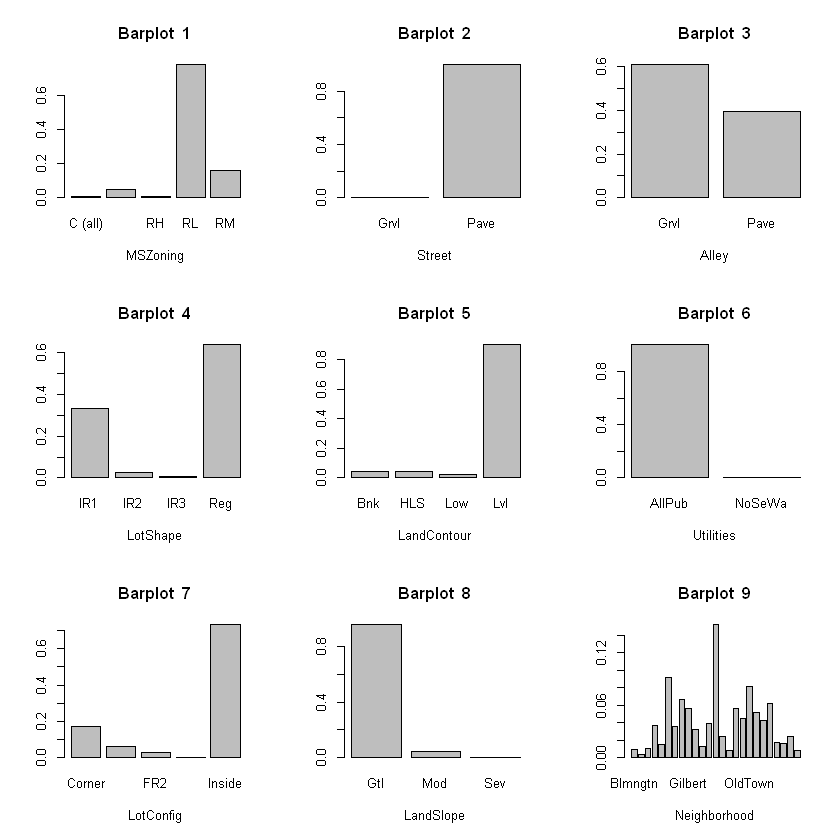

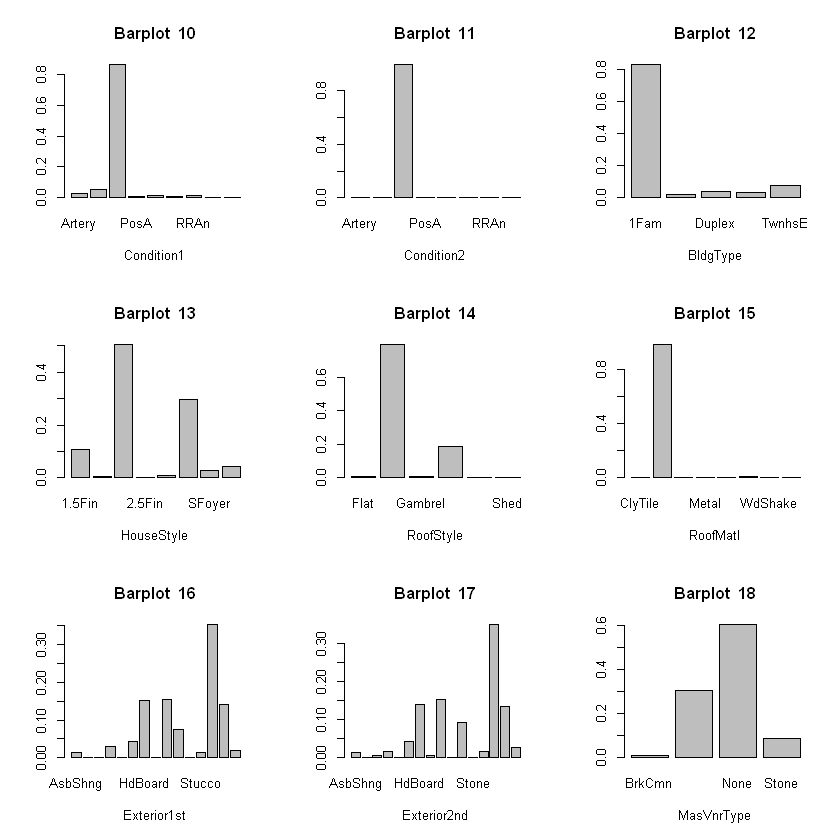

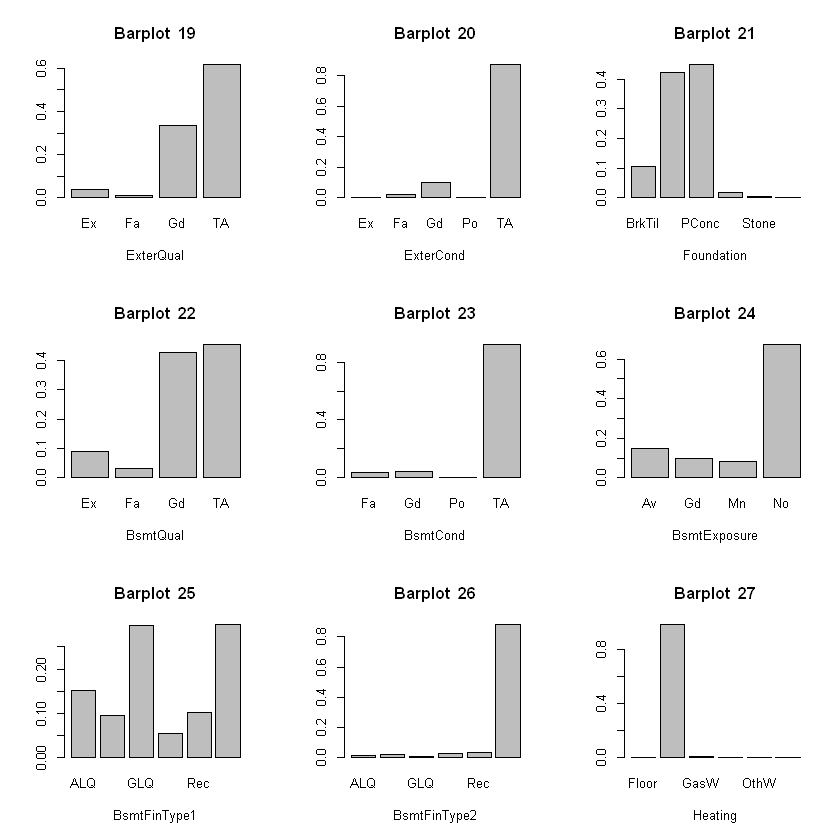

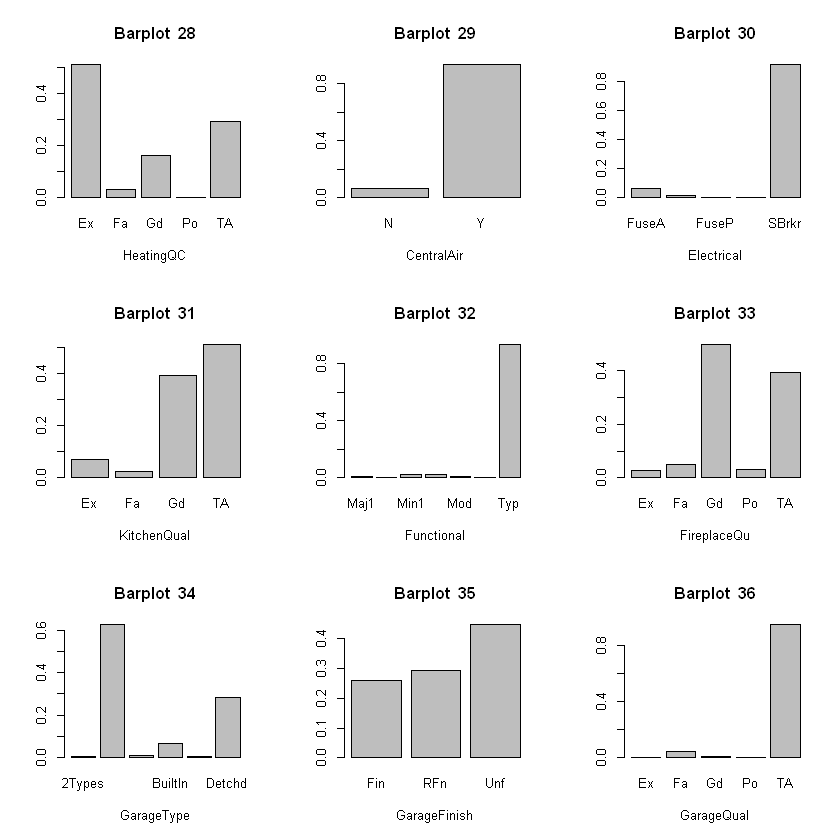

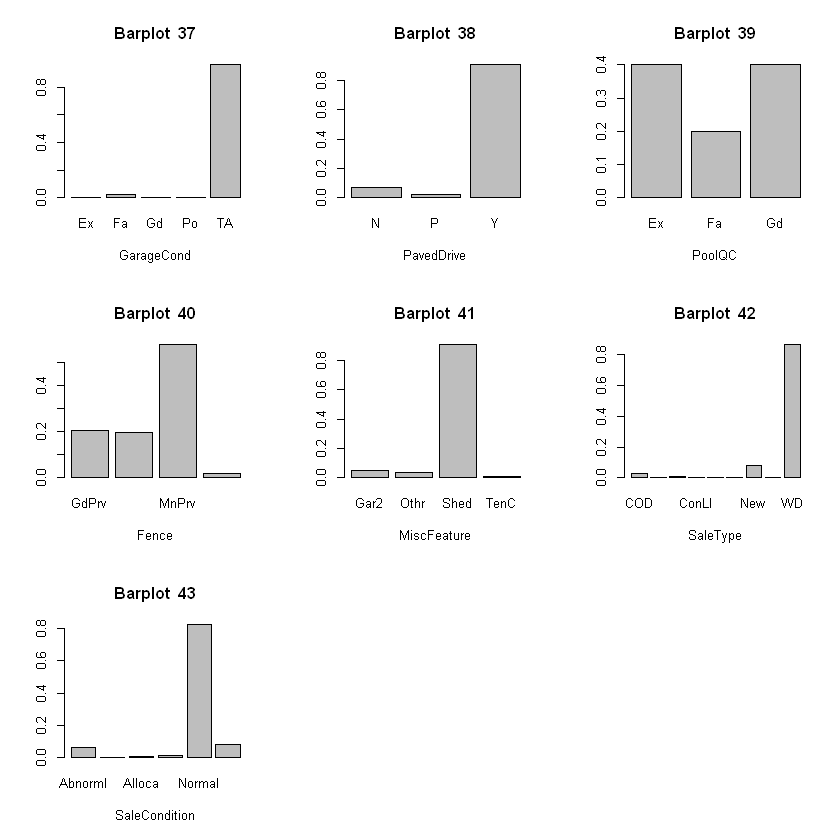

In [25]:
par(mfrow=c(3,3))
plotHist(categoric.df, 1:ncol(categoric.df))

By looking at the histograms for categorical data remove all feature where most values fall into 1 cat:

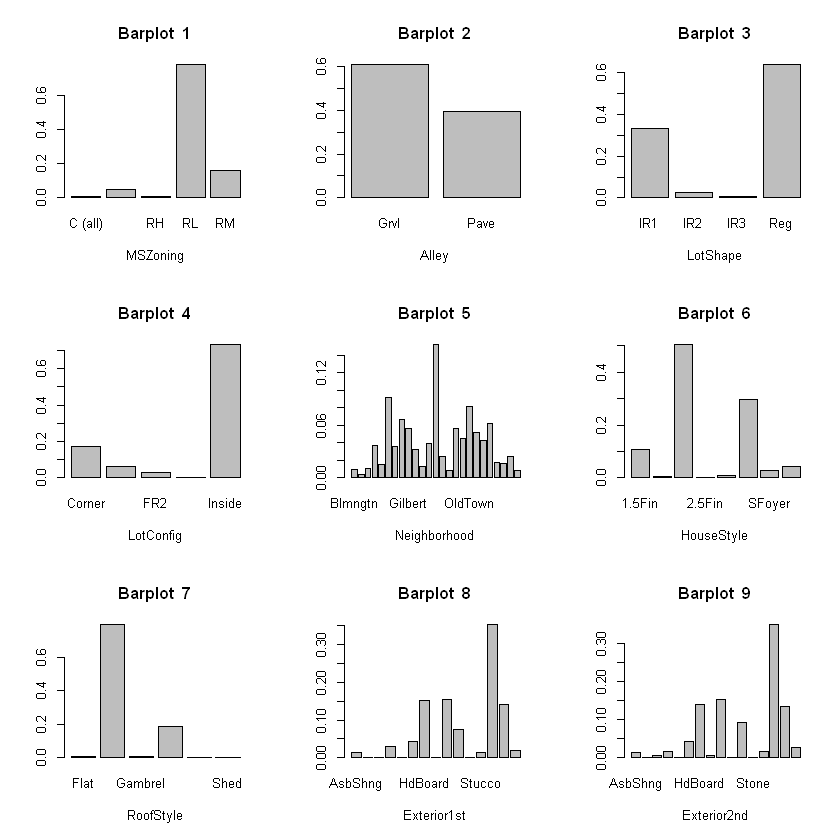

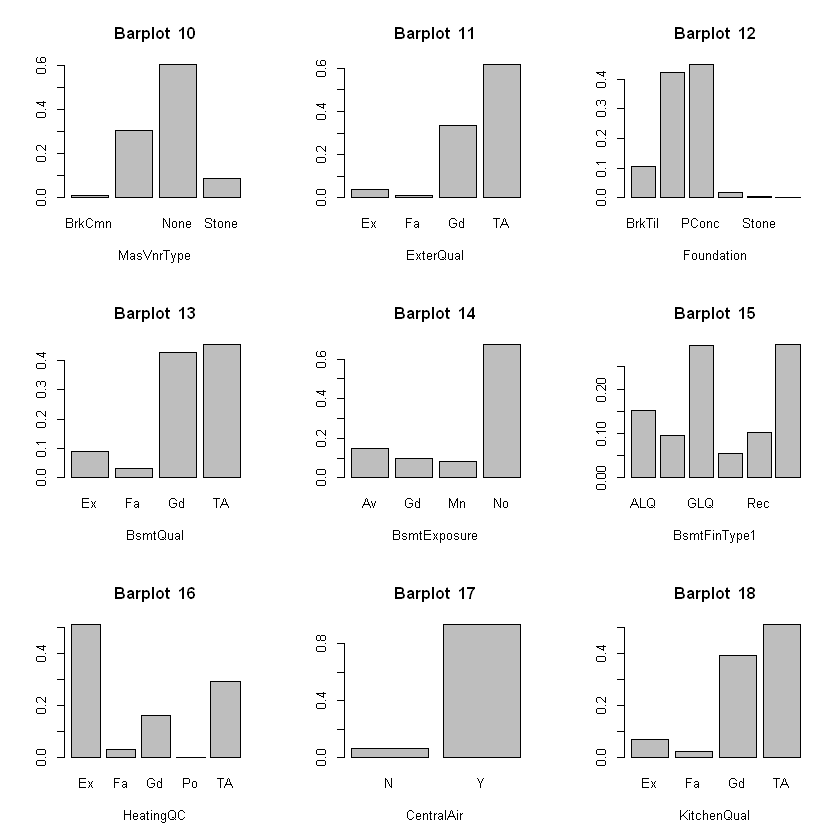

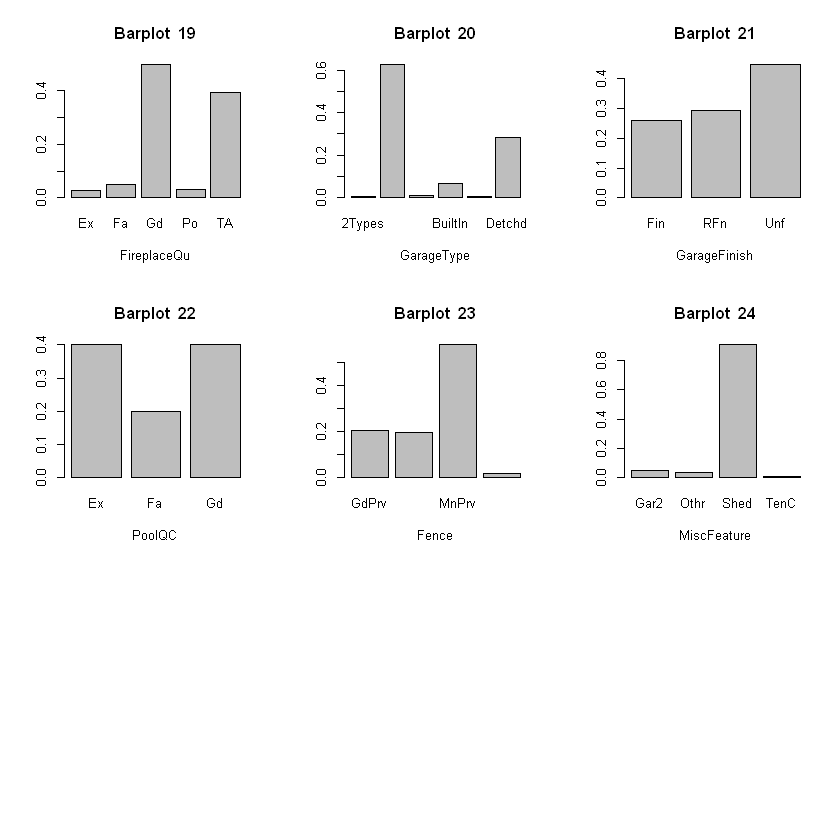

In [28]:
one_dominant_feature <- c('Street',"LandContour","Utilities", "LandSlope", 'Condition1', 'Condition2', 'BldgType', 'RoofMatl',
                          'ExterCond', 'BsmtCond', 'BsmtFinType2', 'Heating', 'Electrical', 'Functional', 'GarageQual',
                          "GarageCond","PavedDrive" , "SaleType" , "SaleCondition")

categoric.df <- categoric.df[,setdiff(names(categoric.df), one_dominant_feature)]
par(mfrow=c(3,3))
plotHist(categoric.df, 1: ncol(categoric.df))

Remove all features for which we don't have enough data:

In [30]:
not_enough_data <- c('MiscFeature', 'Fence', 'PoolQC', 'FireplaceQu', 'GarageFinish', 'BsmtQual', 'BsmtExposure', 
                     'BsmtFinType1', 'MasVnrType', 'GarageType', 'CentralAir' , 'Alley')

categoric.df <- categoric.df[,setdiff(names(categoric.df), not_enough_data)]


colSums(is.na(categoric.df))

MSZoning     LotShape    LotConfig Neighborhood   HouseStyle    RoofStyle 
           4            0            0            0            0            0 
 Exterior1st  Exterior2nd    ExterQual   Foundation    HeatingQC  KitchenQual 
           1            1            0            0            0            1

Impute missing values with the most frequent value on the column:


In [32]:
categoric.df[is.na(categoric.df$MSZoning), 'MSZoning'] <-names(sort(table(categoric.df$MSZoning), decreasing = TRUE)[1])
categoric.df[is.na(categoric.df$Exterior1st), 'Exterior1st'] <-names(sort(table(categoric.df$Exterior1st), decreasing = TRUE)[1])
categoric.df[is.na(categoric.df$Exterior2nd), 'Exterior2nd'] <-names(sort(table(categoric.df$Exterior2nd), decreasing = TRUE)[1])
categoric.df[is.na(categoric.df$KitchenQual), 'KitchenQual'] <-names(sort(table(categoric.df$KitchenQual), decreasing = TRUE)[1])


#Make sure there are no missing values
colSums(is.na(categoric.df))

MSZoning     LotShape    LotConfig Neighborhood   HouseStyle    RoofStyle 
           0            0            0            0            0            0 
 Exterior1st  Exterior2nd    ExterQual   Foundation    HeatingQC  KitchenQual 
           0            0            0            0            0            0

One hot encoding phase:

In [35]:
dim(categoric.df)

#one hot encoding phase
data_factor_onehot <- dummy.data.frame(categoric.df, sep="_")
dim(data_factor_onehot)

[1] 2919   12

[1] 2919  103

### Numeric data visualisation and imputation 

In [37]:
colSums(is.na(numeric.df))
numeric.df$Id <-NULL #remove id

MSSubClass   LotFrontage       LotArea   OverallQual   OverallCond 
            0           486             0             0             0 
    YearBuilt  YearRemodAdd    MasVnrArea    BsmtFinSF1    BsmtFinSF2 
            0             0            23             1             1 
    BsmtUnfSF   TotalBsmtSF     X1stFlrSF     X2ndFlrSF  LowQualFinSF 
            1             1             0             0             0 
    GrLivArea  BsmtFullBath  BsmtHalfBath      FullBath      HalfBath 
            0             2             2             0             0 
 BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd    Fireplaces   GarageYrBlt 
            0             0             0             0           159 
   GarageCars    GarageArea    WoodDeckSF   OpenPorchSF EnclosedPorch 
            1             1             0             0             0 
   X3SsnPorch   ScreenPorch      PoolArea       MiscVal        MoSold 
            0             0             0             0             0 
       YrSold 
            0

Let's find relationships between features.

All basement features seem to be related

In [47]:
if( 'BsmtFinSF1' %in% names(numeric.df) ){
    bsmt <- numeric.df[, c('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF')]
    bsmt$SumBsmt <- bsmt$BsmtFinSF1 + bsmt$BsmtFinSF2 + bsmt$BsmtUnfSF
    par(mfrow=c(1,1))
    corrplot(cor(bsmt,use="complete.obs"),type = 'upper', method='color', addCoef.col = 'green')
    #because TotalBsmtSF is totally corellated with the sum of 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF' we
    #can simplify our model by keeping just the total
    numeric.df$BsmtFinSF1 <- NULL  
    numeric.df$BsmtFinSF2 <- NULL 
    numeric.df$BsmtUnfSF <- NULL 
}


In [48]:
#Ground area surfaces also seem to be related
if( 'X1stFlrSF' %in% names(numeric.df) ){
    area <- numeric.df[, c('X1stFlrSF', 'X2ndFlrSF', 'LowQualFinSF', 'GrLivArea')]
    area$SumArea <- area$X1stFlrSF + area$X2ndFlrSF + area$LowQualFinSF
    par(mfrow=c(1,1))
    corrplot(cor(area,use="complete.obs"),type = 'upper', method='color', addCoef.col = 'green')
    #because GrLivArea is totally corellated with the sum of 'X1stFlrSF', 'X2ndFlrSF', 'LowQualFinSF' we
    #can simplify our model by keeping just the total
    numeric.df$X1stFlrSF <- NULL  
    numeric.df$X2ndFlrSF <- NULL 
    numeric.df$LowQualFinSF <- NULL 
}

In [50]:
#Remove features with a lot of missing data
numeric.df$LotFrontage <- NULL
numeric.df$GarageYrBlt <- NULL

In [52]:
#For remaining features let's impute with mean
replace_na_with_mean_value <- function(vec) {
  mean_vec <- mean(vec, na.rm = TRUE)
  vec[is.na(vec)] <- mean_vec
  vec
}


numeric.df <- data.frame(apply(numeric.df, 2, replace_na_with_mean_value))

At this point we have no missing data!

In [53]:
colSums(is.na(numeric.df))

MSSubClass       LotArea   OverallQual   OverallCond     YearBuilt 
            0             0             0             0             0 
 YearRemodAdd    MasVnrArea   TotalBsmtSF     GrLivArea  BsmtFullBath 
            0             0             0             0             0 
 BsmtHalfBath      FullBath      HalfBath  BedroomAbvGr  KitchenAbvGr 
            0             0             0             0             0 
 TotRmsAbvGrd    Fireplaces    GarageCars    GarageArea    WoodDeckSF 
            0             0             0             0             0 
  OpenPorchSF EnclosedPorch    X3SsnPorch   ScreenPorch      PoolArea 
            0             0             0             0             0 
      MiscVal        MoSold        YrSold 
            0             0             0

### Ouput overview

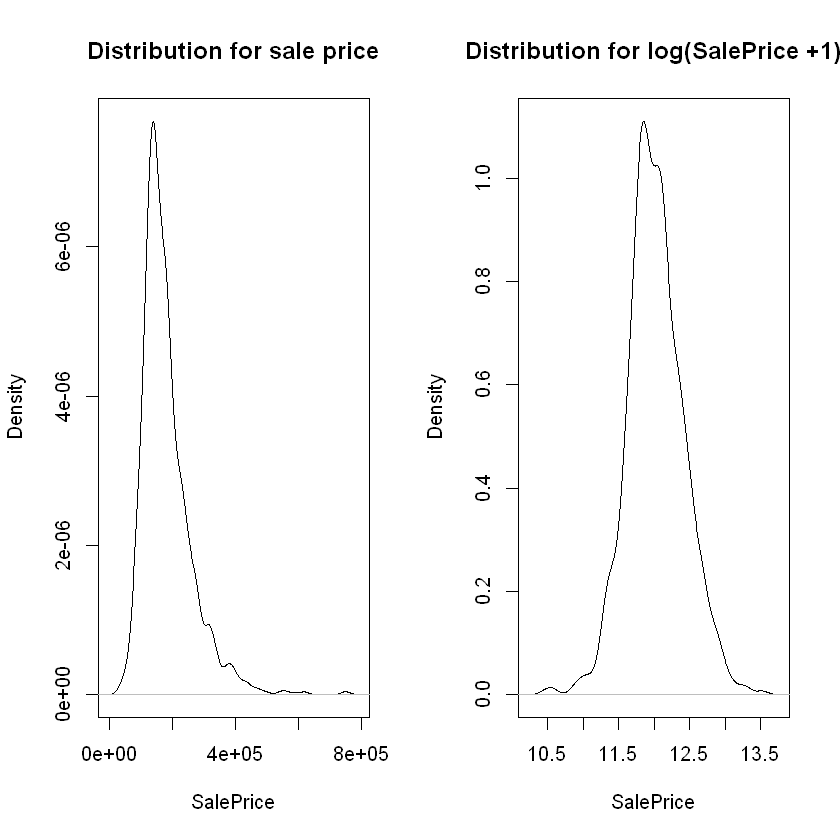

In [56]:
par(mfrow=c(1,2))
#let's examine the output
plot(density(input$SalePrice), xlab = 'SalePrice', 'Distribution for sale price') 
#the distribution of sale prices is right-skewed and does not follow a gaussian
plot(density(log(input$SalePrice + 1)), xlab = 'SalePrice', 'Distribution for log(SalePrice +1)')

In [57]:
X<- numeric.df[1:nrow(input),]
Y<-log(input$SalePrice + 1)
N<-nrow(X)    #Number of examples
n<-ncol(X)    #Number of input variables

train<-cbind(X ,SalePrice=Y)
test <- numeric.df[(nrow(input) + 1):nrow(numeric.df),]
test <- cbind(numeric.df[(nrow(input) + 1):nrow(numeric.df),] , data_factor_onehot[(nrow(input) + 1):nrow(numeric.df),]) 


Let's check dependencies between features and SalePrice:


In [59]:
plotOutputDependency <- function(data_in, output, positions) {
  for (i in positions) {
    plot(data_in[[i]], output, xlab = colnames(data_in)[i], ylab = 'SalePrice', main = paste('Dependency ' , i))
  }
}

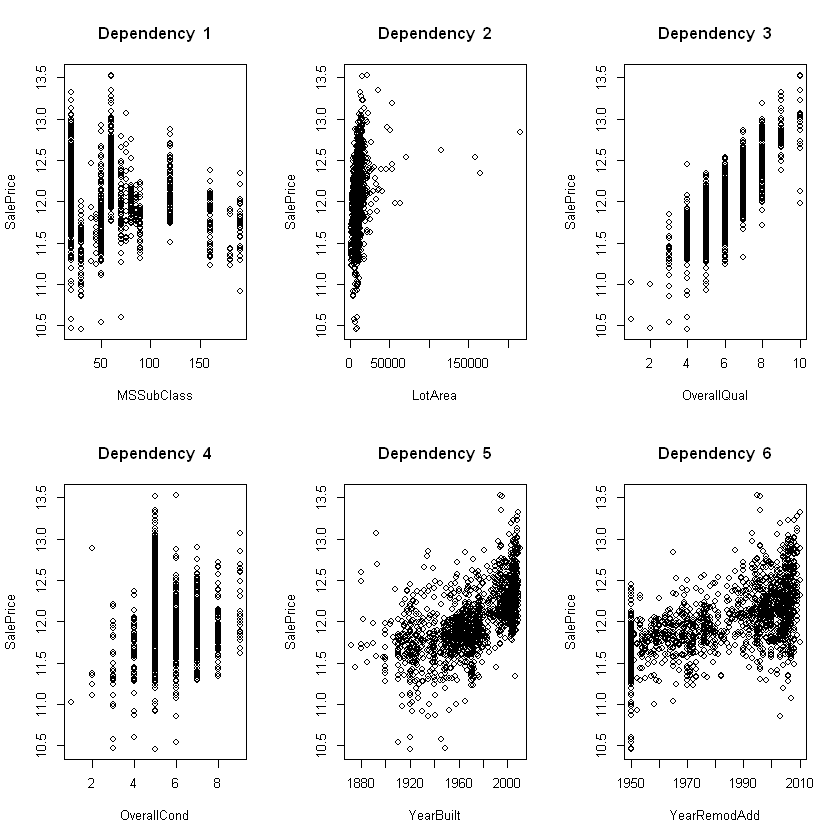

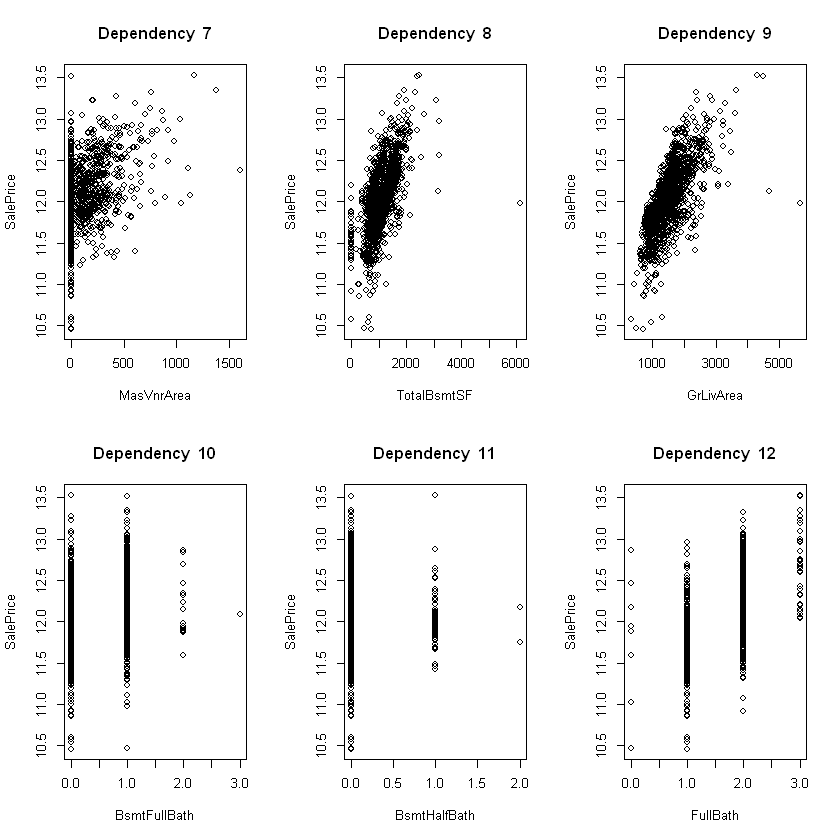

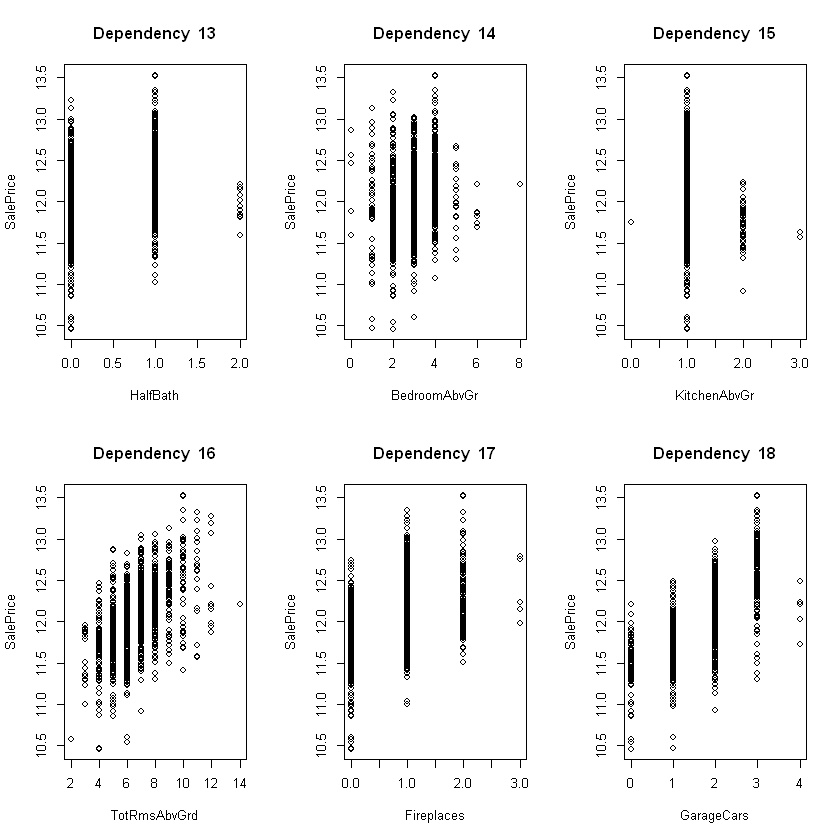

ERROR: Error in .subset2(x, i, exact = exact): subscript out of bounds


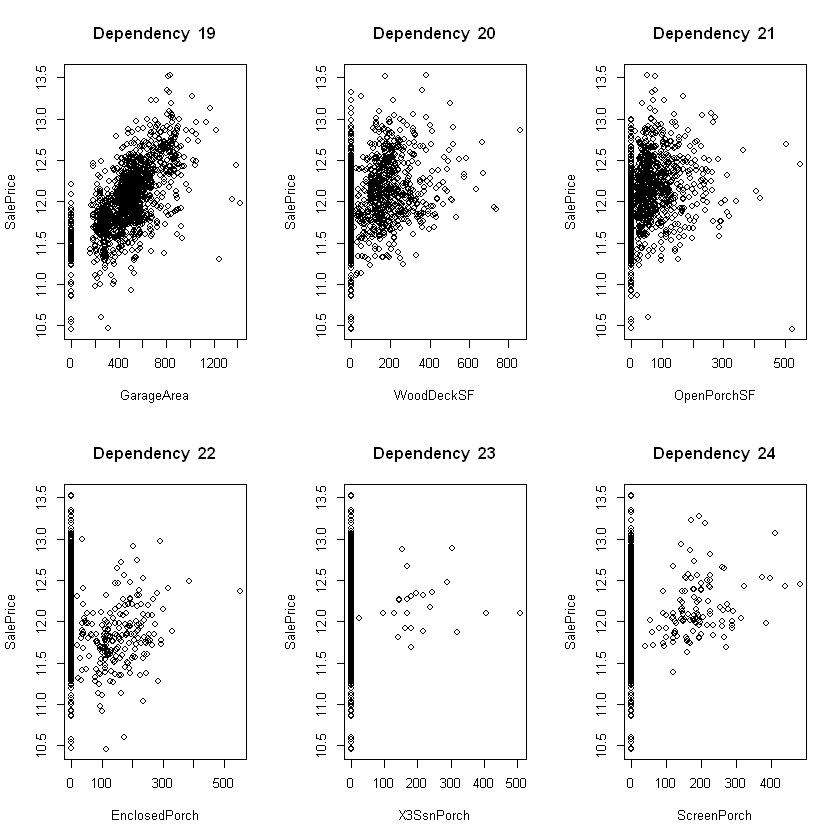

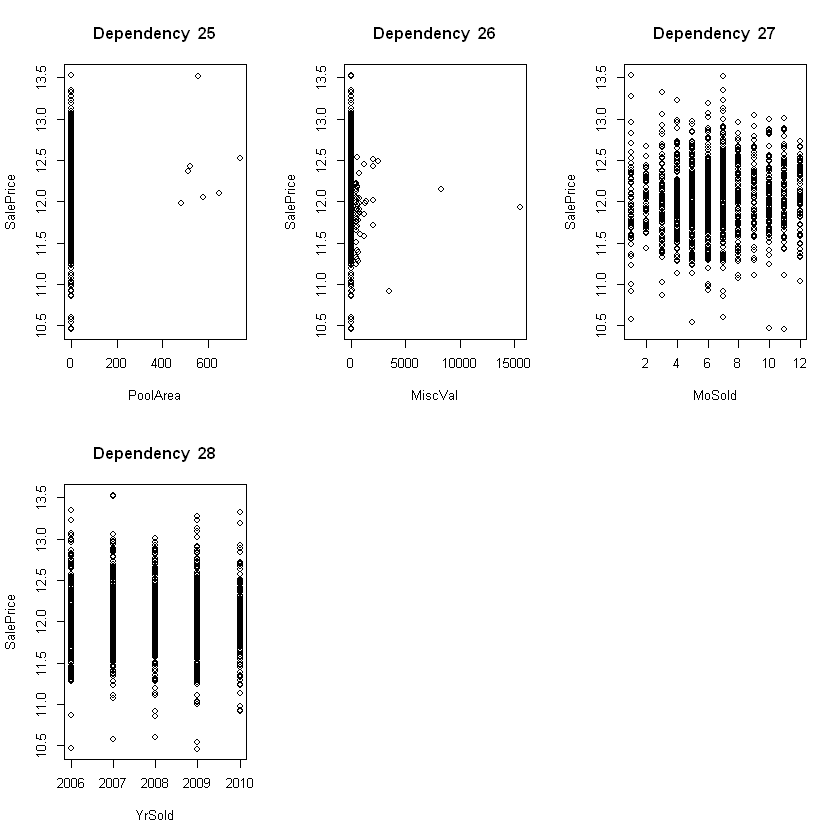

In [61]:
par(mfrow=c(2,3))
plotOutputDependency(X, Y, 1:29)

`geom_smooth()` using method = 'gam'


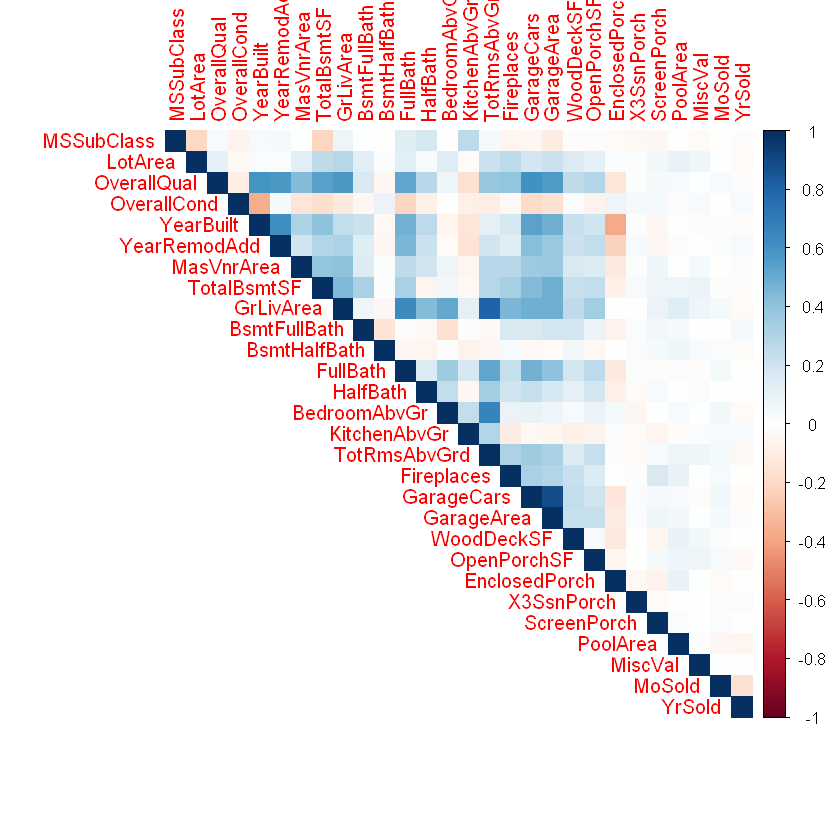

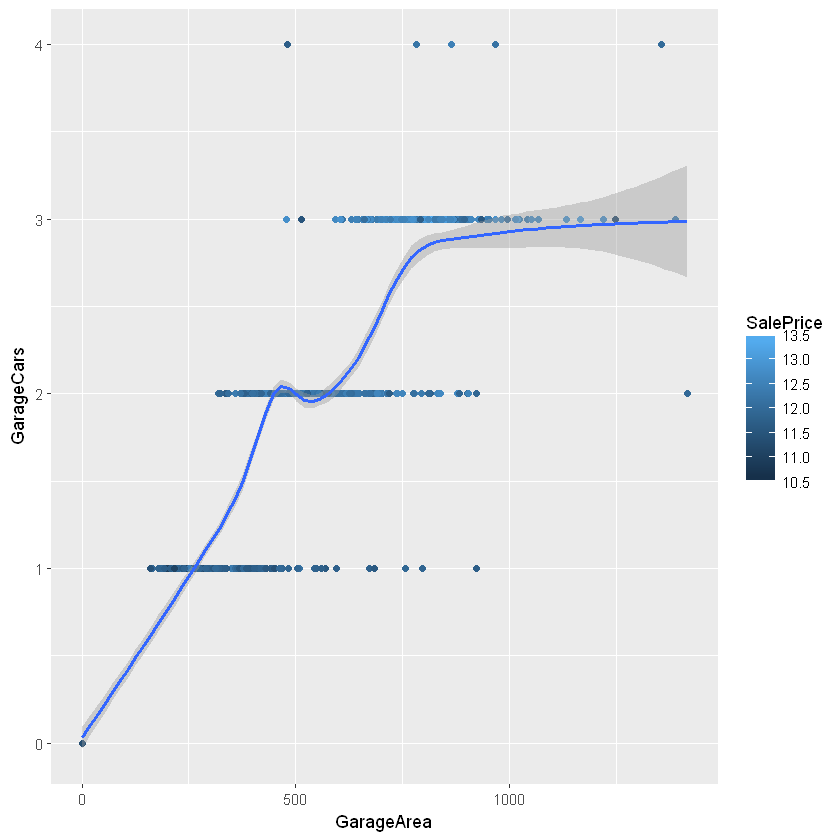

In [62]:
#Explore possible correlations between parameters
corrplot(cor(numeric.df,use="complete.obs"),type = 'upper', method='color')

ggplot(train, aes(x = GarageArea, y = GarageCars, color = SalePrice)) +
  geom_point() + geom_smooth()+ scale_fill_brewer(palette = "Spectral")

There are some dependencies we can explore in order to reduce features, for instance GarageArea is liniarly dependent on GarageCars.

We can do the same thing for categorical data too.

## Feature selection


In [69]:
filterFeatures <- function(modelName, X, Y, minCorrelation){
  size.CV<-floor(N/10)
  
  CV.err<-matrix(0,nrow=n,ncol=10)
  print(dim(CV.err))
  numberOfFeatures <- n
  for (i in 1:10) {
    i.ts<-(((i-1)*size.CV+1):(i*size.CV))  
    X.ts<-X[i.ts,]  
    Y.ts<-Y[i.ts]  
    
    i.tr<-setdiff(1:N,i.ts)
    X.tr<-X[i.tr,]
    Y.tr<-Y[i.tr]
    
    correlation<-abs(cor(X.tr,Y.tr))
    correlation <- correlation[which(correlation[,1] > minCorrelation),]
    ranking<-sort(correlation,dec=T,index.return=T)$ix
    
    numberOfFeatures <- length(correlation)
    
    for (nb_features in 1:numberOfFeatures) {
      DS<-cbind(X.tr[,ranking[1:nb_features],drop=F],sale_price=Y.tr)
      #print(paste('Trying features ', names(DS)));
      model<- rpart(sale_price~.,DS)
      
      Y.hat.ts<- predict(model,X.ts[,ranking[1:nb_features],drop=F])
      
      CV.err[nb_features,i]<-mean((Y.hat.ts-Y.ts)^2)
    }
  }  
  
  writeLines(paste("#Features: ",c(1:numberOfFeatures)," ; CV error=",round(apply(CV.err,1,mean),digits=4), " ; std dev=",round(apply(CV.err,1,sd),digits=4)))
}


In [83]:
#filterFeatures('rpart', X, Y, 0)

The minimum redundancy maximum relevance feature selection strategy approximates


\begin{equation}
  \arg\max_{x_{k}\in X - X_{S}} \left(I\left\{X_{S}; x_{k}\right\};y\right)
\end{equation}


with


\begin{equation}
  x^*_{MRMR}=\arg\max_{x_{k}\in X - X_{S}} \left[I(x_{k}; y) - \frac{1}{m} \sum_{x_{i}\in X_{S}} I(x_{i}; x_{k})\right]
\end{equation}

where $m$ is the size of $X_S$


In [91]:

mrmr <- function(X, Y) {
  size.CV<-floor(N/10)
  
  CV.err<-matrix(0,nrow=n,ncol=10)
  
  for (i in 1:10) {
    i.ts<-(((i-1)*size.CV+1):(i*size.CV))  
    X.ts<-X[i.ts,]  
    Y.ts<-Y[i.ts]  
    
    i.tr<-setdiff(1:N,i.ts)
    X.tr<-X[i.tr,]
    Y.tr<-Y[i.tr]
    
    
    correlation<-abs(cor(X.tr,Y.tr))
    
    selected<-c()
    candidates<-1:n
    
    #mRMR ranks the variables by taking account not only the correlation with the output, but also by avoiding redudant variables
    for (j in 1:n) {
      redudancy.score<-numeric(length(candidates))
      if (length(selected)>0) {
        cor.selected.candidates<-cor(X.tr[,selected,drop=F],X.tr[,candidates,drop=F])
        redudancy.score<-apply(cor.selected.candidates,2,mean)
         print(paste('cor.selected.candidates : ' , dim(cor.selected.candidates))) 
          print(paste('redudancy.score : ' , length(redudancy.score)))
			print(paste('X.tr[,selected,drop=F] : ' , dim(X.tr[,selected,drop=F])))
			print(paste('X.tr[,candidates,drop=F] : ' , dim(X.tr[,candidates,drop=F])))

        #print(paste('cor.selected.candidates : ', cor.selected.candidates, ' redudancy.score ', redudancy.score))
      }
      
      mRMR.score<-correlation[candidates]-redudancy.score
      #print(paste('redudancy.score : ', redudancy.score, '  correlation[candidates] : ', correlation[candidates]))
      selected_current<-candidates[which.max(mRMR.score)]
      selected<-c(selected,selected_current)
      candidates<-setdiff(candidates,selected_current)
      #print(paste(' mRMR.score: ', mRMR.score, ' selected_current : ', selected_current, ' selected :' , selected, ' candidates: ', candidates))
    }
    
    ranking<-selected
    #print(ranking)
    
    for (nb_features in 1:n) {
      DS<-cbind(X.tr[,ranking[1:nb_features],drop=F],imdb_score=Y.tr)
      #print(names(DS))
      model<- rpart(imdb_score~.,DS)
      
      Y.hat.ts<- predict(model,X.ts[,ranking[1:nb_features],drop=F])
      
      CV.err[nb_features,i]<-mean((Y.hat.ts-Y.ts)^2)
    }
  }  
  
  writeLines(paste("#Features: ",c(1:n)," ; CV error=",round(apply(CV.err,1,mean),digits=4), " ; std dev=",round(apply(CV.err,1,sd),digits=4)))
}

In [92]:
mrmr(X,Y)

[1] "cor.selected.candidates :  1"  "cor.selected.candidates :  27"
[1] "redudancy.score :  27"
[1] "X.tr[,selected,drop=F] :  1314" "X.tr[,selected,drop=F] :  1"   
[1] "X.tr[,candidates,drop=F] :  1314" "X.tr[,candidates,drop=F] :  27"  
[1] "cor.selected.candidates :  2"  "cor.selected.candidates :  26"
[1] "redudancy.score :  26"
[1] "X.tr[,selected,drop=F] :  1314" "X.tr[,selected,drop=F] :  2"   
[1] "X.tr[,candidates,drop=F] :  1314" "X.tr[,candidates,drop=F] :  26"  
[1] "cor.selected.candidates :  3"  "cor.selected.candidates :  25"
[1] "redudancy.score :  25"
[1] "X.tr[,selected,drop=F] :  1314" "X.tr[,selected,drop=F] :  3"   
[1] "X.tr[,candidates,drop=F] :  1314" "X.tr[,candidates,drop=F] :  25"  
[1] "cor.selected.candidates :  4"  "cor.selected.candidates :  24"
[1] "redudancy.score :  24"
[1] "X.tr[,selected,drop=F] :  1314" "X.tr[,selected,drop=F] :  4"   
[1] "X.tr[,candidates,drop=F] :  1314" "X.tr[,candidates,drop=F] :  24"  
[1] "cor.selected.candidates :  5"  "cor

In [77]:
forwardSelection <- function(X, Y) {
  size.CV<-floor(N/10)
  
  selected<-NULL
  
  for (round in 1:n) { 
    candidates<-setdiff(1:n,selected)
    
    CV.err<-matrix(0,nrow=length(candidates),ncol=10)
    
    for (j in 1:length(candidates)) {
      features_to_include<-c(selected,candidates[j])
      
      for (i in 1:10) {
        i.ts<-(((i-1)*size.CV+1):(i*size.CV))  
        X.ts<-X[i.ts,features_to_include,drop=F]  
        Y.ts<-Y[i.ts]  
        
        i.tr<-setdiff(1:N,i.ts)
        X.tr<-X[i.tr,features_to_include,drop=F]
        Y.tr<-Y[i.tr]
        
        DS<-cbind(X.tr,imdb_score=Y.tr)
        model<- rpart(imdb_score~.,DS)
        
        Y.hat.ts<- predict(model,X.ts)
        
        CV.err[j,i]<-mean((Y.hat.ts-Y.ts)^2)
      }
    }
    CV.err.mean<-apply(CV.err,1,mean)
    CV.err.sd<-apply(CV.err,1,sd)
    selected_current<-which.min(CV.err.mean)              
    selected<-c(selected,candidates[selected_current])
    print(paste("Round ",round," ; Selected feature: ",candidates[selected_current]," ; CV error=",round(CV.err.mean[selected_current],digits=4), " ; std dev=",round(CV.err.sd[selected_current],digits=4)))
    
  }
  
  print(paste('colnames(X)[selected] :', colnames(X)[selected]))
  print(paste('colnames(X) ', colnames(X)))
}

In [78]:
#forwardSelection(X,Y)

### Create cross validated models

The root mean squared error function between the logarithm of the predicted value and the logarithm of the observed sales price to evaluate model performance:

In [63]:
rmse <- function (log_prediction, log_observation){
  sqrt(mean(log_prediction-log_observation)^2)
}


Generic method which runs given model and calculates 10 fold cross validation:

In [64]:
runModel <- function(modelName, X, Y){
  if(modelName == 'nnet'){
    X <- scale(X)
  }
  
  size.CV<-floor(N/10)
  
  CV.err<-numeric(10)
  
  for (i in 1:10) {
    i.ts<-(((i-1)*size.CV+1):(i*size.CV))  ### Complete the code. i.ts should be the indices of the tessefor the i-th fold
    X.ts<-X[i.ts,]  
    Y.ts<-Y[i.ts]  
    
    i.tr<-setdiff(1:N,i.ts)                ### Complete the code. i.tr should be the indices of the training sefor the i-th fold
    X.tr<-X[i.tr,]
    Y.tr<-Y[i.tr]                          
    
    DS<-cbind(X.tr,sale_price=Y.tr)
    
    if(modelName == 'rpart') {
      model<- rpart(sale_price~.,DS)
      Y.hat.ts<- predict(model,X.ts)
    }
    if(modelName == 'svm'){
      model<- svm(sale_price~.,DS, scale = T, center=T, kernel = 'radial', 
                  shrinking = T, cross = 10, cost = 4, epislon = 0.2)
      Y.hat.ts<- predict(model,X.ts)
    }
    if(modelName == 'nnet'){
      model<- nnet(sale_price~.,DS, size =3, linout = TRUE, maxit=150, decay=0.3)
      Y.hat.ts<- predict(model,X.ts)
    }
    if(modelName == 'lazy'){
      model<- lazy(sale_price~.,DS)
      Y.hat.ts<- predict(model,X.ts)$h
    }
    CV.err[i]<-rmse(Y.hat.ts,Y.ts) 
  }
  print(paste(modelName, "  CV error=",round(mean(CV.err),digits=4), " ; std dev=",round(sd(CV.err),digits=4)))
}

Ensemble model calculating 10 fold cross validation on 20 samples:

In [65]:
runEnsemble <- function(modelName, X, Y){
  if(modelName == 'nnet'){
    X <- scale(X)
  }
  R<-20
  size.CV<-floor(N/10)
  
  CV.err<-numeric(10)
  
  for (i in 1:10) {
    i.ts<-(((i-1)*size.CV+1):(i*size.CV))  ### Complete the code. i.ts should be the indices of the tessefor the i-th fold
    X.ts<-X[i.ts,]  
    Y.ts<-Y[i.ts]  
    
    i.tr<-setdiff(1:N,i.ts)                ### Complete the code. i.tr should be the indices of the training sefor the i-th fold
    Y.hat.ts.R<-matrix(0,nrow=nrow(X.ts),ncol=R)
    
    for (r in 1:R) {
      i.tr.resample<-sample(i.tr,rep=T)
      X.tr<-X[i.tr.resample,]
      Y.tr<-Y[i.tr.resample]       
      
      DS<-cbind(X.tr,sale_price=Y.tr)
      
      if(modelName == 'rpart') {
        model<- rpart(sale_price~.,DS)
        Y.hat.ts.R[,r]<- predict(model,X.ts)
      }
      if(modelName == 'svm'){
        model<- svm(sale_price~.,DS, scale = T, center=T, kernel = 'radial', 
                    shrinking = T, cross = 10, cost = 4, epislon = 0.2)
        Y.hat.ts.R[,r]<- predict(model,X.ts)
      }
      if(modelName == 'nnet'){
        model<- nnet(sale_price~.,DS, size =3, linout = TRUE, maxit=150, decay=0.3)
        Y.hat.ts.R[,r]<- predict(model,X.ts)
      }
      if(modelName == 'lazy'){
        model<- lazy(sale_price~.,DS)
        Y.hat.ts.R[,r]<- predict(model,X.ts)$h
      }
      
    }
    
    Y.hat.ts<-apply(Y.hat.ts.R,1,mean)
    CV.err[i]<-rmse(Y.hat.ts,Y.ts)
  }
  
  
  print(paste('Ensemble ', modelName, "  CV error=",round(mean(CV.err),digits=4), " ; std dev=",round(sd(CV.err),digits=4)))
}


runModel('rpart', X, Y)
runEnsemble('rpart', X, Y)

runModel('lazy', X, Y)
runEnsemble('lazy', X, Y)


runModel('svm', X, Y)
runEnsemble('svm', X, Y)


runModel('knn', X, Y)
runEnsemble('knn', X, Y)

runModel('nnet', X, Y)
runEnsemble('nnet', X, Y)

In [67]:
runModel('rpart', X, Y)

[1] "rpart   CV error= 0.0142  ; std dev= 0.0109"


### Prediction

The following method writes to submission.csv the result outputed by given selection.

It recalculates original price as we transformed y = log(y_i + 1)

In [79]:
writePredictionToFile <- function (prediction) {
  predictedSalePrice <- exp(prediction) -1
  result <- cbind(Id = output$Id, SalePrice = predictedSalePrice )
  colnames(result) <- c("Id","SalePrice")
  write.csv(result, "submission.csv",row.names=FALSE)
}


In [80]:
model<- rpart(SalePrice~.,train)
prediction<- predict(model,test)

In [81]:
writePredictionToFile(prediction)